In [101]:
import pandas as pd
import numpy as np
import re
import string

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [102]:
lemmatizer = WordNetLemmatizer()

In [103]:
# Lets open the file and and extract all the content line by line into a list
with open(r"E:\داده کاوی\6 ۱۱دی\Health-Tweets\bbchealth.txt") as file:
    contents = file.readlines()
    
# Fancy regex for extracting data. Because I'm awesome and I refuse to split it.
regex = re.compile(r'(?P<tweet_id>.*)\|(?P<date>.*)\|(?P<news>.*)\s?(?P<link>http://.*)')

In [104]:
# I hope the regex words
re.search(regex, contents[0]).groupdict()

# And it worked. Cool

{'tweet_id': '585978391360221184',
 'date': 'Thu Apr 09 01:31:50 +0000 2015',
 'news': 'Breast cancer risk test devised ',
 'link': 'http://bbc.in/1CimpJF'}

In [105]:
# You all know this. Don't pretend that you don't.
df = pd.DataFrame(columns=['tweet_id', 'date', 'news', 'link'])

# Self explanatory
for line in contents:
    line_data = re.search(regex, line).groupdict()
    df = df.append(line_data, ignore_index=True)

In [106]:
# Our dataset looks like this. Not too shabby.
df.head()

,tweet_id,date,news,link
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised,http://bbc.in/1CimpJF
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll,http://bbc.in/1ChTBRv
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater',http://bbc.in/1ChTANp
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising',http://bbc.in/1E6jAjt
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors,http://bbc.in/1CnLwK7


In [107]:
df.shape

(3929, 4)

In [108]:
# Lets define some function to normalize, lemmatize the line and getting POS tags. 
# Normalizing, the following methods in order -- lower, strip white spaces, remove punctiations and 
# digits, and finally word tokenizing

def normalize(line):
    line = line.lower().strip()
    line = ''.join([char for char in line if char not in string.punctuation+string.digits])
    return word_tokenize(line)

# Lemmatizing each word in each line
def lemmatize_sent(line_tokens):
    return list(map(lemmatizer.lemmatize, line_tokens))

# POS tagging, This one returns just the POS tags in order.
def tokens(line_tokens):
    word_tags = pos_tag(line_tokens)
    return list(zip(*word_tags))[1]

In [109]:
# Let's apply all those functions to the columns.
df['news_tokens'] = df['news'].map(normalize)
df['corresponding_tags'] = df['news_tokens'].map(tokens)
df['lemmatized_news_tokens'] = df['news_tokens'].map(lemmatize_sent)

In [110]:
# Dropping unnecessary columns, that I think I don't need.
df.drop(labels=['link'], inplace=True, axis=1)
df.drop(labels=['tweet_id'], inplace=True, axis=1)

In [111]:
# Let's see what our dataset looks like again
df.head()

,date,news,news_tokens,corresponding_tags,lemmatized_news_tokens
0,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised,"[breast, cancer, risk, test, devised]","(NN, NN, NN, NN, VBD)","[breast, cancer, risk, test, devised]"
1,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll,"[gp, workload, harming, care, bma, poll]","(NN, NN, VBG, NN, NN, NN)","[gp, workload, harming, care, bma, poll]"
2,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater',"[short, peoples, heart, risk, greater]","(JJ, NNS, NN, NN, JJR)","[short, people, heart, risk, greater]"
3,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising',"[new, approach, against, hiv, promising]","(JJ, NN, IN, NN, NN)","[new, approach, against, hiv, promising]"
4,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors,"[coalition, undermined, nhs, doctors]","(NN, VBD, JJ, NNS)","[coalition, undermined, nh, doctor]"


In [112]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['lemmatized_news_tokens'].map(lambda x: ' '.join(x)).tolist())

## KMeans Clstering

In [68]:
kmeans = KMeans(n_clusters= 13)
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=13)

In [69]:
# Yup, right number of labels.
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [70]:
tfidf_matrix

<3929x3955 sparse matrix of type '<class 'numpy.float64'>'
	with 22123 stored elements in Compressed Sparse Row format>

## PCA

In [75]:
import time
time_start = time.time()

pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.A)

print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 0.8596057891845703 seconds


(-0.4, 0.4)

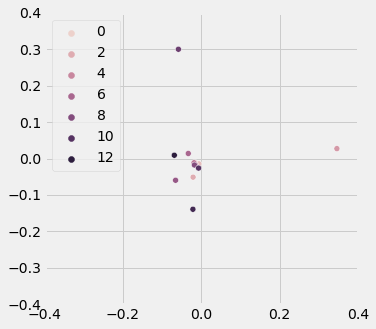

In [72]:
plt.figure(figsize=(5, 5))
cluster_centers = pca.fit_transform(kmeans.cluster_centers_)
sns.scatterplot(x=cluster_centers[:,0], y=cluster_centers[:,1], hue=np.unique(kmeans.labels_))
    
plt.xlim((-0.4, 0.4))
plt.ylim((-0.4, 0.4))

<AxesSubplot:>

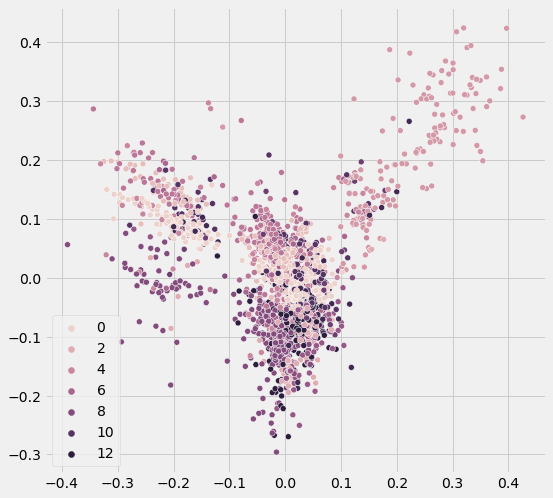

In [73]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=pca_matrix[:,0], y=pca_matrix[:,1], hue=kmeans.labels_)

In [25]:
# Did you just think we're gonna stop at 2D plots?
# If you did, you're wrong buddy. Behold 3D plots.
pca_3d = PCA(n_components=3)
pca_matrix_3d = pca_3d.fit_transform(tfidf_matrix.A)

In [20]:
# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(111, projection='3d')
# for p, l in zip(pca_matrix_3d, kmeans.labels_):
#     plt.scatter(*p, 'bgrcmykw'[l])

## Tsne

In [41]:
from sklearn.manifold import TSNE

In [60]:
import time
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(tfidf_matrix.A)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3929 samples in 0.025s...
[t-SNE] Computed neighbors for 3929 samples in 1.897s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3929
[t-SNE] Computed conditional probabilities for sample 2000 / 3929
[t-SNE] Computed conditional probabilities for sample 3000 / 3929
[t-SNE] Computed conditional probabilities for sample 3929 / 3929
[t-SNE] Mean sigma: 0.345952
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.013130
[t-SNE] KL divergence after 300 iterations: 3.707389
t-SNE done! Time elapsed: 20.318779230117798 seconds


<AxesSubplot:>

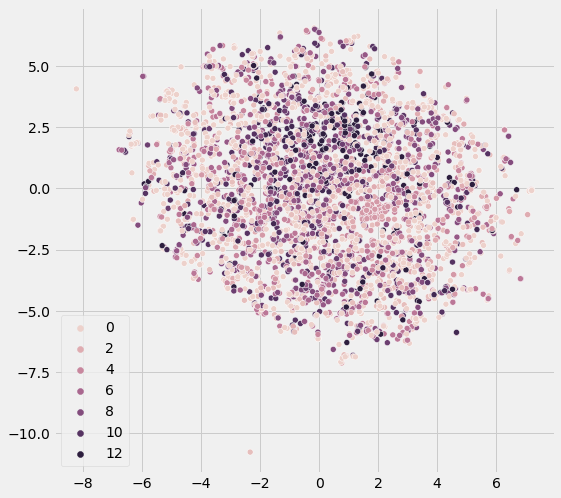

In [76]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=kmeans.labels_)

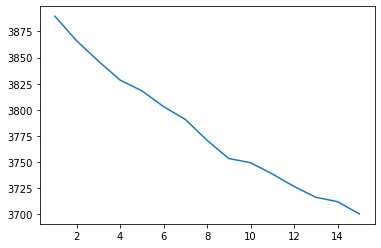

In [26]:
# Now, for elbow method. We'll try clustering from k=1 to k=15 and see how well the curve is displayed
x, y = [], []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    x.append(k)
    y.append(kmeans.inertia_)
    
plt.plot(x, y)

In [24]:
# That suck. Where's the elbow?
# Let's see how sihoutte score goes.
# For those who doesn't know what silhoutte score is,
# The silhoutte score is a value of measure of closeness
# to it's own cluster(cohesion) compared to other clusters(seperation)
# it ranges from [-1, 1]. A high value indicates how well matched is
# an object is to it's cluster.
# For more info, wikipedia is your guy.

# We'll calculate silhoutte scores for the same range as before excpet 1
# Because it'll throw an error if k = 1. Because you know,
# how well a point is matched to it's cluster and there exists one cluster.
# Make sense to you. It doesn't to me.

In [39]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, kmeans.labels_)
    silhouette_coefficients.append(score)

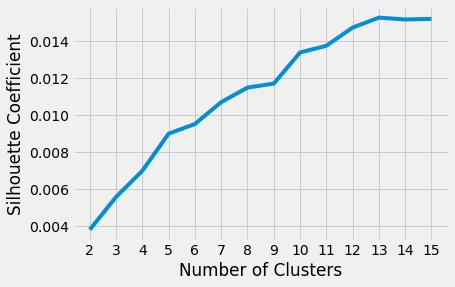

In [40]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 16), silhouette_coefficients)
plt.xticks(range(2, 16))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

## DBSCAN Clustering

In [240]:
clustering = DBSCAN(eps = 0.981 , min_samples= 5).fit(tfidf_matrix)

In [241]:
np.unique(clustering.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=int64)

In [242]:
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.A)

<AxesSubplot:>

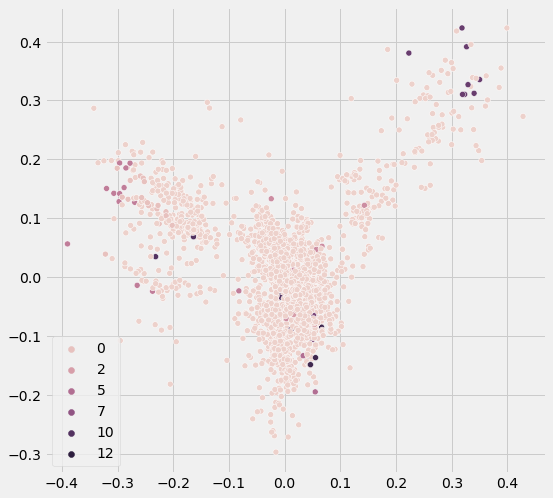

In [243]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=pca_matrix[:,0], y=pca_matrix[:,1], hue=clustering.labels_)

## SpectralClustering

In [121]:
from sklearn.cluster import SpectralClustering

In [122]:
clustering = SpectralClustering(n_clusters= 13,
         assign_labels='discretize',
         random_state=0).fit(tfidf_matrix)

In [123]:
clustering.labels_

array([ 5,  6,  1, ...,  7, 10,  2], dtype=int64)

In [124]:
clustering

SpectralClustering(assign_labels='discretize', n_clusters=13, random_state=0)

In [125]:
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.A)

<AxesSubplot:>

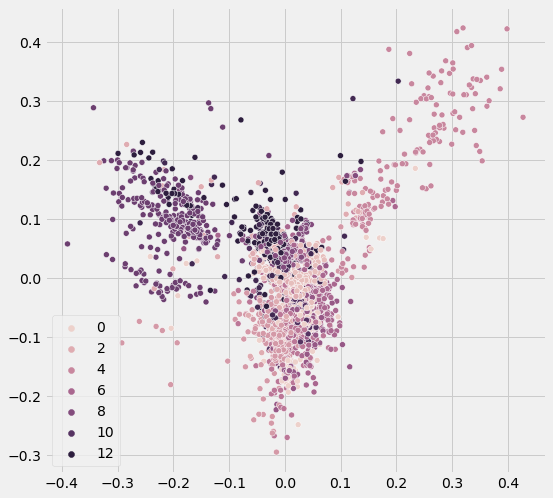

In [126]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=pca_matrix[:,0], y=pca_matrix[:,1], hue=clustering.labels_)

## AgglomerativeClustering

In [216]:
from sklearn.cluster import AgglomerativeClustering

In [219]:
tfidf_matrix = tfidf_matrix.todense()

In [220]:
clustering = AgglomerativeClustering(n_clusters= 13).fit(tfidf_matrix)

In [221]:
clustering.labels_

array([8, 1, 1, ..., 2, 3, 2], dtype=int64)

In [222]:
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.A)

<AxesSubplot:>

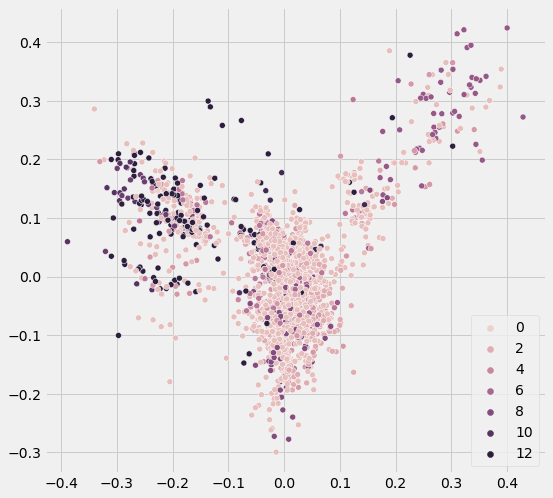

In [223]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=pca_matrix[:,0], y=pca_matrix[:,1], hue=clustering.labels_)